<a href="https://colab.research.google.com/github/khaqanashraf/pest-detection/blob/main/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('./gdrive/')

Mounted at ./gdrive/


In [ ]:
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import validation_curve
from torch.autograd import Variable
import pandas as pd
from pathlib import Path
import pandas as pd

In [ ]:
# Install timm to import pretrained ViT
!pip install timm

     |████████████████████████████████| 376 kB 8.1 MB/s 


In [ ]:
import timm
from pprint import pprint

In [ ]:
# Unzip dataset folder if it is in .zip format
# !unzip './gdrive/My Drive/Pest Detection/train.zip' -d './gdrive/My Drive/Pest Detection/wheat rust/'


In [ ]:
# create device string and check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [ ]:
# define path to the directory used to do experiment
DATADIR = './gdrive/My Drive/Pest Detection/wheat rust'

In [ ]:
# Load images dataset with Augumentation

batch_size = 16
Datatransforms = transforms.Compose([transforms.Resize(384),
                                       transforms.CenterCrop(384),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ])

train_data = datasets.ImageFolder(DATADIR + '/train', transform=Datatransforms)
test_data = ImageFolderWithPaths(DATADIR + '/test', transform=Datatransforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['healthy_wheat', 'leaf_rust', 'stem_rust']


In [ ]:
test_data

Dataset ImageFolderWithPaths
    Number of datapoints: 610
    Root location: ./gdrive/My Drive/Pest Detection/wheat rust/test
    StandardTransform
Transform: Compose(
               Resize(size=384, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(384, 384))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 875
    Root location: ./gdrive/My Drive/Pest Detection/wheat rust/train
    StandardTransform
Transform: Compose(
               Resize(size=384, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(384, 384))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# define method to visualize data points
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# get first batch of data points
inputs, classes = next(iter(trainloader))
inputs.shape, classes.shape

(torch.Size([16, 3, 384, 384]), torch.Size([16]))

In [ ]:
classes.to(device)

tensor([2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 1], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


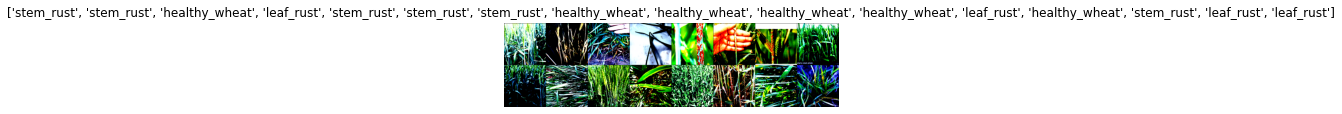

In [ ]:
# visulaize a batch
show_databatch(inputs, classes)

In [ ]:
# get vailable pretrained models provided by timm library
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [ ]:
# import pretrained ViT model
# name of the model can be chosen from the names listed above
model = timm.create_model('vit_tiny_patch16_384', pretrained=True)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): 

In [ ]:
# freeze all layers of the pretrained model
for param in model.parameters():
    param.requires_grad = False

In [ ]:
num_features = model.head.in_features
num_features

192

In [ ]:
# Transfer Learning
# append our own classifier at the top of the pretrained model
drop_out = 0.1
newClassifierLayers = [nn.Linear(num_features, 512) , nn.Tanh() , nn.Dropout(p =drop_out)  ]
newClassifierLayers.extend([nn.Linear(512, len(class_names))])
newClassifierLayers
model.head = nn.Sequential(*newClassifierLayers)


In [ ]:
# visualize and verify the model topology
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): 

In [ ]:
# load model from the directry if already saved model
# model.load_state_dict(torch.load(DATADIR+"/experiment_92.pth", map_location=torch.device('cpu')))
# model.load_state_dict(torch.load(DATADIR+"/experiment_87.pth"))


In [ ]:
# initialize loss and optimizer to be used
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

In [ ]:
def train(e=10, name="xyz"):
    model.train()
    for epoch in range(e):  # loop over the dataset multiple times
        start_time = time.time()
        running_loss = 0.0
        running_accuracy = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_accuracy += (preds == labels).sum().item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        print(running_loss/len(trainloader.dataset), ", ",  running_accuracy/len(trainloader.dataset), ",",  time.time() - start_time)
        torch.save(model.state_dict(), DATADIR+"/"+name+".pth")

In [ ]:
# train and save model in the directory
train(20, "experiment_123")

0.05475293929236276 ,  0.5942857142857143 , 354.44134306907654
0.03948172133309501 ,  0.7782857142857142 , 113.56217503547668
0.03360900953837803 ,  0.8137142857142857 , 114.32240509986877
0.029175184386117117 ,  0.8548571428571429 , 112.34443974494934
0.026645957384790694 ,  0.864 , 113.26299548149109
0.02483971754142216 ,  0.888 , 113.40036535263062
0.02270977589062282 ,  0.8914285714285715 , 113.99813175201416
0.020988284179142544 ,  0.9017142857142857 , 114.15386533737183
0.01934805268900735 ,  0.9188571428571428 , 114.10222029685974
0.018224382596356527 ,  0.9222857142857143 , 113.32718181610107
0.016924448115485054 ,  0.928 , 112.56748533248901
0.016169029210294995 ,  0.936 , 114.6037015914917
0.014913392279829298 ,  0.9394285714285714 , 112.23488545417786
0.014091716613088336 ,  0.9405714285714286 , 114.72058320045471
0.01360643834727151 ,  0.9417142857142857 , 112.26951694488525
0.012622136835541043 ,  0.9451428571428572 , 113.6201560497284
0.012127260501895632 ,  0.95885714285

In [ ]:
# evaluate model and get predictions
model.eval()

my_softmax = nn.Softmax(dim=-1)
my_sigmoid = nn.Sigmoid()
results = []

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels, fname = data[0].to(device), data[1].to(device), data[2]

        outputs = model(images)
        image_names = np.array(fname).reshape(len(fname), 1)
        probabilities = my_softmax(outputs).detach().cpu().numpy()
        output_probabilities = probabilities
        print(probabilities)
        results.extend( np.hstack((image_names, output_probabilities)))


i = 0
for rec in results:
    name = rec[0].split('/')[-1]
    results[i][0] = name.split('.')[0]
    # print(results[i][0], name)
    i+=1

cols = ['ID']
cols.extend(class_names)
df = pd.DataFrame(results, columns=cols)

new_df = df.drop(columns=['healthy_wheat'])
new_df['health_wheat'] = df.healthy_wheat

new_df.to_csv(DATADIR + '/experiment_123.csv', index=False)

[[1.15422001e-02 3.83126400e-02 9.50145245e-01]
 [9.11444128e-01 8.18252787e-02 6.73059793e-03]
 [2.65318155e-02 8.92296016e-01 8.11721608e-02]
 [8.64464045e-03 8.70137736e-02 9.04341578e-01]
 [3.57682444e-02 1.85225978e-01 7.79005766e-01]
 [5.14653206e-01 9.58711728e-02 3.89475614e-01]
 [7.46974409e-01 1.89888030e-01 6.31375313e-02]
 [9.67185080e-01 1.48104317e-02 1.80045459e-02]
 [1.43578164e-02 2.31250692e-02 9.62517202e-01]
 [3.01161036e-03 9.86787081e-01 1.02013545e-02]
 [1.25591992e-03 4.35941696e-01 5.62802315e-01]
 [7.75539409e-03 8.96196961e-01 9.60476622e-02]
 [9.93517321e-03 3.27593237e-01 6.62471592e-01]
 [6.51370676e-04 9.57856238e-01 4.14924212e-02]
 [9.31881648e-03 9.27399218e-01 6.32818937e-02]
 [3.33345553e-04 9.90538359e-01 9.12830513e-03]]
[[2.6455724e-03 9.8670352e-01 1.0650901e-02]
 [6.3313448e-01 3.4553412e-01 2.1331424e-02]
 [3.2341781e-03 2.0177209e-01 7.9499376e-01]
 [7.4905506e-03 1.7325631e-01 8.1925315e-01]
 [1.8050425e-02 2.7221246e-02 9.5472836e-01]
 [5.94